<a href="https://colab.research.google.com/github/NivedithaVelaga/product-recommendation-system/blob/main/Model_based_collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ngkTWXQyL27ePwwrcfUkSuSqOQ8q6gXB?usp=sharing)

##Importing libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

## Importing Dataset

In [ ]:
#Import the data set
df = pd.read_csv('/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

In [ ]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  51778
No of columns =  3


### Datatypes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51778 entries, 0 to 51777
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  51778 non-null  object 
 1   prod_id  51778 non-null  object 
 2   rating   51777 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


### Missing value analysis

In [ ]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,0
rating,1


### Summary

In [ ]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,51777.000000
mean,4.036503
std,1.354294
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Rating distribution

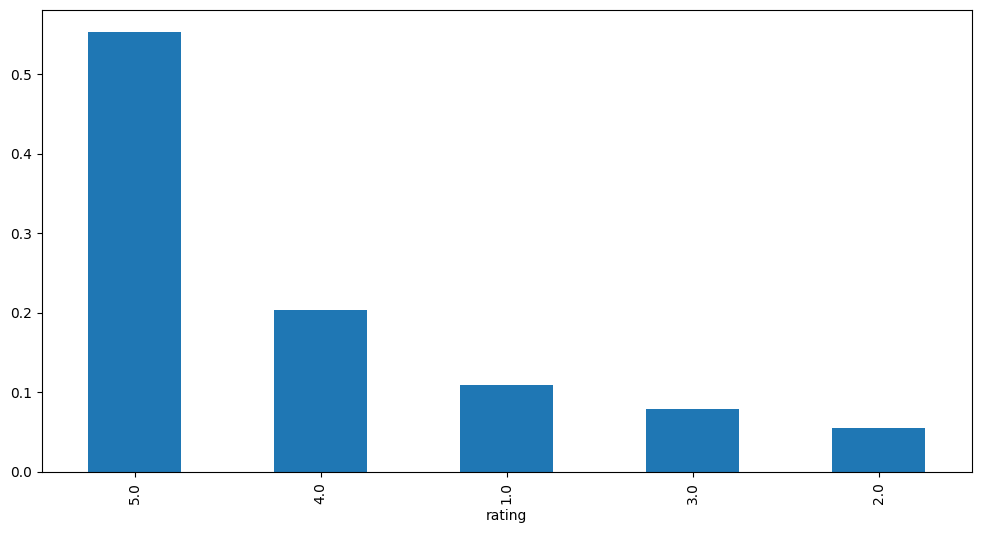

In [ ]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  48098
Number of unique ITEMS in Raw data =  3615


### Users with most no of rating

In [ ]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A231WM2Z2JL0U3,38
AY8Q1X7G96HV5,32
A1NVD0TKNS1GT5,21
ALUNVOQRXOZIA,20
A243HY69GIAHFI,18
A1RPTVW5VEOSI,17
A1MJMYLRTZ76ZX,17
A1ISUNUWG0K02V,16
A7Y6AVS576M03,15


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [ ]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 0
Number of unique USERS in the final data =  0
Number of unique PRODUCTS in the final data =  0


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [ ]:
# 1. FIX THE DATA (Relax the filter to >= 2 ratings)
# This ensures you actually have data to work with
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 2].index)]

print(f"Data fixed! New size: {len(df_final)} rows")

# 2. NOW create the interaction matrix
final_ratings_matrix = df_final.pivot(index='user_id', columns='prod_id', values='rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

# 3. Calculate Density (This will work now because size is not 0)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
density = (given_num_of_ratings / possible_num_of_ratings) * 100

print ('density: {:4.2f}%'.format(density))
final_ratings_matrix.head()

Data fixed! New size: 5958 rows
Shape of final_ratings_matrix:  (2278, 1604)
density: 0.16%


prod_id,0594017343,0594017580,0594033926,0594296420,0594450705,0594451647,0594477670,0970407998,0972683275,0979526191,...,B00004TVSO,B00004TVSP,B00004TWLX,B00004TWLY,B00004TWM0,B00004TWM2,B00004TWM3,B00004TWM4,B00004TWM5,B00004TWM6
user_id,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101OAAMZYWQ3U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105GWGM7PDAI2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105R38CAPDBGU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10ARISO1UMIUN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model based Collaborative Filtering: Singular Value Decomposition

**We have seen above that the interaction matrix is highly sparse. SVD is best to apply on a large sparse matrix. Note that for sparse matrices, we can use the sparse.linalg.svds() function to perform the decomposition**

Also, we will use **k=50 latent features** to predict rating of products

## CSR matrix

In [ ]:
from scipy.sparse import csr_matrix
final_ratings_sparse = csr_matrix(final_ratings_matrix.values)


## SVD

In [ ]:
# Singular Value Decomposition
U, s, Vt = svds(final_ratings_sparse, k = 50) # here k is the number of latent features

# Construct diagonal array in SVD
sigma = np.diag(s)

In [ ]:
U.shape

(2278, 50)

In [ ]:
sigma.shape

(50, 50)

In [ ]:
Vt.shape

(50, 1604)

Now, let's regenerate the original matrix using U, Sigma, and Vt matrices. The resulting matrix would be the predicted ratings for all users and products

## Predicting ratings

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Predicted ratings
preds_df = pd.DataFrame(abs(all_user_predicted_ratings), columns = final_ratings_matrix.columns)
preds_df.head()
preds_matrix = csr_matrix(preds_df.values)

## Function to recommend products

In [ ]:
import numpy as np

def recommend_items(user_index, interactions_matrix, preds_matrix, num_recommendations):

    # Get the user's ratings from the actual and predicted interaction matrices
    user_ratings = interactions_matrix[user_index,:].toarray().reshape(-1)
    user_predictions = preds_matrix[user_index,:].toarray().reshape(-1)

    #Creating a dataframe with actual and predicted ratings columns
    temp = pd.DataFrame({'user_ratings': user_ratings, 'user_predictions': user_predictions})
    temp['Recommended Products'] = np.arange(len(user_ratings))
    temp = temp.set_index('Recommended Products')

    #Filtering the dataframe where actual ratings are 0 which implies that the user has not interacted with that product
    temp = temp.loc[temp.user_ratings == 0]

    #Recommending products with top predicted ratings
    temp = temp.sort_values('user_predictions',ascending=False)#Sort the dataframe by user_predictions in descending order
    print('\nBelow are the recommended products for user(user_id = {}):\n'.format(user_index))
    print(temp['user_predictions'].head(num_recommendations))


### Recommending top 5 products to user id 121

In [ ]:
#Enter 'user index' and 'num_recommendations' for the user
recommend_items(121,final_ratings_sparse,preds_matrix,5)


Below are the recommended products for user(user_id = 121):

Recommended Products
929     0.166111
1141    0.141002
343     0.082613
169     0.079294
950     0.072288
Name: user_predictions, dtype: float64


### Recommending top 10 products to user id 100

In [ ]:
recommend_items(100,final_ratings_sparse,preds_matrix,10)


Below are the recommended products for user(user_id = 100):

Recommended Products
1085    0.183688
443     0.179263
949     0.138754
850     0.137910
814     0.137894
1079    0.116251
895     0.113417
1479    0.106156
1055    0.102247
1125    0.102238
Name: user_predictions, dtype: float64


## Evaluating the model





In [ ]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594017343,0594017580,0594033926,0594296420,0594450705,0594451647,0594477670,0970407998,0972683275,0979526191,...,B00004TVSO,B00004TVSP,B00004TWLX,B00004TWLY,B00004TWM0,B00004TWM2,B00004TWM3,B00004TWM4,B00004TWM5,B00004TWM6
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
average_rating = final_ratings_matrix.mean()
average_rating.head()

,0
prod_id,
0594017343,0.000439
0594017580,0.001317
0594033926,0.003951
0594296420,0.002195
0594450705,0.002195


In [ ]:
preds_df.head()

prod_id,0594017343,0594017580,0594033926,0594296420,0594450705,0594451647,0594477670,0970407998,0972683275,0979526191,...,B00004TVSO,B00004TVSP,B00004TWLX,B00004TWLY,B00004TWM0,B00004TWM2,B00004TWM3,B00004TWM4,B00004TWM5,B00004TWM6
0,1.850782e-06,2.198201e-05,6.967970e-04,4.784543e-06,3.040667e-06,0.000208,1.560942e-05,1.846343e-04,2.315662e-01,0.036987,...,0.001680,0.004492,0.000653,6.876153e-05,0.005570,0.004630,0.138231,2.224456e-03,1.862736e-03,0.000702
1,2.084786e-08,2.341423e-08,2.980390e-07,1.040664e-07,2.406272e-09,0.000001,1.609799e-08,5.790830e-07,5.366519e-07,0.000006,...,0.000003,0.000010,0.000006,6.148385e-08,0.000061,0.000002,0.000021,6.807618e-07,3.095063e-07,0.000002
2,1.244535e-04,1.574172e-04,4.026916e-03,4.945733e-05,1.940689e-05,0.003578,1.395362e-04,7.036710e-03,4.062173e-02,0.001237,...,0.079637,0.004276,0.008753,3.681577e-03,0.007480,0.005773,0.005766,3.926505e-04,1.211284e-01,0.012661
3,3.858660e-06,2.389779e-06,1.298496e-05,5.206576e-06,1.165516e-07,0.000148,7.433072e-07,8.874761e-04,9.057314e-04,0.000162,...,0.000528,0.000196,0.000440,2.645978e-05,0.000638,0.001015,0.001241,2.871234e-06,1.097808e-03,0.000356
4,8.164656e-06,3.097992e-05,1.027956e-03,1.183590e-05,2.568787e-06,0.000793,3.450899e-07,9.788412e-04,1.764047e-02,0.001625,...,0.005179,0.006150,0.006151,2.925527e-04,0.011625,0.001962,0.022296,5.254285e-04,2.609046e-03,0.000456


In [ ]:
avg_preds=preds_df.mean()
avg_preds.head()

,0
prod_id,
0594017343,0.000093
0594017580,0.000150
0594033926,0.002598
0594296420,0.000095
0594450705,0.000012


In [ ]:
rmse_df = pd.concat([average_rating, avg_preds], axis=1)

rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']

rmse_df.head()

,Avg_actual_ratings,Avg_predicted_ratings
prod_id,,
0594017343,0.000439,0.000093
0594017580,0.001317,0.000150
0594033926,0.003951,0.002598
0594296420,0.002195,0.000095
0594450705,0.002195,0.000012


In [ ]:
RMSE=mean_squared_error(rmse_df['Avg_actual_ratings'], rmse_df['Avg_predicted_ratings'], squared=False)
print(f'RMSE SVD Model = {RMSE} \n')